# Project 2 Lab Book

Jan Forslow, Jason Harville, Dan Wald

**Code Note:** The majority of the code we used in this project is located in project_functions.py, which is imported above as pfn. Please refer to this file for a closer look at any of the code used in this lab book.

**Code Warning:** As this project required the automated downloading, processing, and merging of nearly 5 GB of data, much of this code may not be appropriate to run a second time while reviewing this notebook. In cases where code is downloading/saving large amounts of data, or where the code is computationally expensive, we have have taken steps to avoid inadvertantly running it. This code has warning comments, and much of the code itself is either commented out or modified to handle a subset of the data for demonstration purposes. It should be clear how to uncomment and correct these modifications if you want to fully reproduce the data downloading and aggregating on your local machine. If you would like direct access to the raw data, it can be found in the source_data directory here: https://drive.google.com/folderview?id=0BxolO_eh8I-8NTUxUWVTY1Fha0E&usp=sharing

**But don't worry...**
It's not necessary to run any of the data downloading/aggregating/merging code in this document, as the we have already compiled and condenced the data into master_combined_data.csv (< 1 MB), from which the code loads the data for analysis. Run the below cell with import statements, and then the first cell of the Analysis section of the lab book, and all subsequent analysis code will run.

In [1]:
# Please run to import necessary modules and functions and enable
# notebook plotting.

%load_ext autoreload
%autoreload 1
%aimport project_functions
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as plt
import urllib.request
from urllib.request import HTTPError
from urllib.request import URLError
import http
import os
import json

import project_functions as pfn

api_key = '2B92C17D184FEB235C00913E20A82629'

## Project Description
No electrical component is 100% efficient. Our national electric grid is composed of thousands of electrical components, and so electrical energy is inevitably lost as it is transmitted from the source of generation to its final end use. It is known that the efficiency of electrical components is affected by both their physical environment (e.g. ambient temperature) and their electromagnetic environment (e.g. the earth's magnetic field), among other things.

This project set out to explore these interactions between electrical power, land weather, and space weather (which affects the earth's magnetic field). We began by identifying datasets for electricity production, consumption, and losses; surface weather and temperatures; and geomagnetic flux. Data is aggregated monthly for the years 2005-2009.

## Data Sources

We identified the following data sources.

#### Magnetic Flux data for space weather:
http://satdat.ngdc.noaa.gov/sem/goes/data/new_avg

Sample file: ./GOES_Data/g15_magneto_1m_20110801_20110831.csv

#### Land surface weather:
Monthly temperature readings from NOAA for contiguous United States (state code 110): http://www7.ncdc.noaa.gov/CDO/CDODivisionalSelect.jsp

#### Electricity: Energy Information Administration:

API: http://www.eia.gov/opendata/qb.cfm?category=711279

Electricity Profile report, table 10: http://www.eia.gov/electricity/state/unitedstates/

Net Generation, monthly
- Commercial: http://www.eia.gov/opendata/qb.cfm?category=26
- Industrial: http://www.eia.gov/opendata/qb.cfm?category=29
- Net Total: http://www.eia.gov/opendata/qb.cfm?category=1

Retail Sales, monthly
- http://www.eia.gov/opendata/qb.cfm?category=38

Trade, annual
- International Net Imports: https://www.eia.gov/opendata/qb.cfm?category=40831
- Interstate Net Imports: https://www.eia.gov/opendata/qb.cfm?category=45561
- Both of the above are also available from Table 10: http://www.eia.gov/electricity/state/

Direct Use, annual
- Table 10: http://www.eia.gov/electricity/state/

### Data Field Descriptions

##### Electricity
- gen_tot: Total net electricity generation.
- gen_com: Total commercial electricity generation.
- gen_ind: Total industrial electricity generation.
- gen_com_ind: Sum of gen_com and gen_ind.
- ret_sales: Total retail sales of electricity.
- direct_use_est: Estimate of electricity used onsite after generation, and never exported to the electric grid.
- net_imports_est: Estimate of net electricity imports.
- losses_est: Estimate of electrical losses, using net_imports_est.
- losses2: Estimate of electrical losses, ignoring net imports.

##### Land Weather
- PCP - Precipitation Index  
- TAVG - Temperature Index  
- TMIN - Minimum Temperature Index  
- TMAX - Maximum Temperature Index  
- PDSI - Palmer Drought Severity Index  
- PHDI - Palmer Hydrological Drought Index  
- ZNDX - Palmer Z-Index  
- PMDI - Modified Palmer Drought Severity Index  
- CDD - Cooling Degree Days
- HDD - Heating Degree Days  
- SPnn - Standard Precipitation Index

Note: CCD is calculated as the number of days * the number of degrees of temperature above baseline. It is used as an indicator of the amount of cooling that is required to maintain baseling. HDD is the opposite. See http://www.degreedays.net/ for definition.

##### Space Weather
- hp: Magnetic field component perpendicular to the earth's orbital plane, positive north.
- ht: Total magnetic field.
- he: Magnetic field component in the Earthward direction, perpendicular to hp.
- hn: Magnetic field in the eastward direction, perpendicular to hp and he.

Magnetic field data is by minute, and so needed to be aggregated to monthly values. Fields with *_function* indicate that the magnetic field data was aggregated using that function. Fields with *_abs_function* indicate that the absolute value of the magnetic field data was aggregated with that function.

### Magnetic Flux Data

Data on magnetic flux is complex, and not located in any single file. NOAA uses multiple geostationary operational environmental satellites (GOES) to measure magnetic flux over different latitudes on earth, and sometimes multiple satellites are taking measurements from the same latitude. For the contintental United States, magnetic flux is measured by satellites at 135 and 75 degrees west, which are labelled GOES West and GOES East, respectively. In addition to multiple satellites, the data is also present in two different formats (new satellites since 2010 use a different format), and contained in separate csv files of minutely measurements for each month/satellite combination.

![title](satellite data flow.png)

In order to gather this data, we had to write code that would automatically download all monthly csv files for the relevant GOESs. This was complicated not only by the number of files, but by the fact that they did not have very standardized naming - which forced us to calculate the appropriate name and header offset for each file.

Warning: running the below code may take a very long time. This is representative, and only for the year 2005. The combined satellite data is ~2.5 GB and should not be downloaded again.

In [2]:
# # Enter your destination folder
# # Please do not enter './GOES_Data/', or else it will write over the existing files
# data_folder = './your_folder_here/'

# months = {
# 'Jan': ['01', '31'],
# 'Feb': ['02', '28'],
# 'Mar': ['03', '31'],
# 'Apr': ['04', '30'],
# 'May': ['05', '31'],
# 'Jun': ['06', '30'],
# 'Jul': ['07', '31'],
# 'Aug': ['08', '31'],
# 'Sep': ['09', '30'],
# 'Oct': ['10', '31'],
# 'Nov': ['11', '30'],
# 'Dec': ['12', '31']}

# # This is set to a single year (2005). Modify the year range to download more than one year.
# for year in range(2005,2006): # could be entry argument
#     for month in months:
#         print(month, year, 'start.')
#         for SatId in range(10,16): # GOES identifiers
#             print('Pulling data from GOES' + str(SatId))
#             if months[month][0] == '02' and year % 4 == 0: # leap year check
#                 MaxDay = '29'
#             else:
#                 MaxDay = str(months[month][1])
            
#             file_name = 'g' + str(SatId) + '_magneto_1m_' + str(year) + months[month][0] + '01_' + str(year) + \
#                         months[month][0] + months[month][1] + '.csv'
#             file_url = 'http://satdat.ngdc.noaa.gov/sem/goes/data/new_avg/' + str(year) + '/' + months[month][0] + \
#                        '/goes' + str(SatId) + '/csv/' + file_name         
#             if pfn.verify_url(file_url) == True:
#                 print('Downloading:', file_url)
#                 urllib.request.urlretrieve(file_url, data_folder + file_name) # save location is here
#                 print(month, year, 'done.')
#             else:
#                 print(month, year, 'GOES_%s dataset empty' % SatId)

After downloading and saving approximately 300 monthly GOES csv files, we needed to combine them. Given the different file formats for 2005-2009 and 2010-2014, we decided to create two large csv files for those two date ranges. We accomplished this by iterating through all csv files in the given range, converting them to dataframes, and then appending them together. Once completed, we saved the combined dataframe as a single csv containing the data from every satellite in every minute of the date range.

In [3]:
# This is set to a single year (2005) for demonstration purposes.
# Modify the year range to aggreagate more than one year. We used 2005-2009.
# Warning: due to irregularities in data from 2010+, this will not work for those files and
# this should not be set for dates from 2010 on. Please only include years

# first = True
# FileDir = './source_data/GOES_Data/'

# months = {
# 'Jan': ['01', '31'],
# 'Feb': ['02', '28'],
# 'Mar': ['03', '31'],
# 'Apr': ['04', '30'],
# 'May': ['05', '31'],
# 'Jun': ['06', '30'],
# 'Jul': ['07', '31'],
# 'Aug': ['08', '31'],
# 'Sep': ['09', '30'],
# 'Oct': ['10', '31'],
# 'Nov': ['11', '30'],
# 'Dec': ['12', '31']}

# for year in range(2005,2006): # could be entry argument
#     for month in months:
#         print(month, year, 'start.')
#         for SatId in range(10,16): # GOES identifiers
#             print('Pulling data from GOES' + str(SatId))
            
#             if months[month][0] == '02' and year % 4 == 0: # leap year check
#                 MaxDay = '29'
#             else:
#                 MaxDay = str(months[month][1])
            
#             file_name = 'g' + str(SatId) + '_magneto_1m_' + str(year) + months[month][0] + '01_' + str(year) + \
#                         months[month][0] + str(MaxDay) + '.csv'
                        
#             if os.path.exists(FileDir + file_name):
#                 print(file_name)
#                 temp = pfn.GOES_csv_to_df(SatId, MaxDay, file_name=file_name, FileDir = FileDir)
#                 YYYY_MM = file_name[-12:-8] + '-' + file_name[-8:-6] # date extraction
#                 if first:
#                     df = temp.copy()
#                     first = False
#                 else: # new month
#                     df = df.append(temp)
#             else:
#                 print('empty set')

            
# df = df.apply(clean_GOES_Data, axis=1)
# print('Saving DataFrame as a .csv')
# #df.to_csv('full_csv_file_path_here') # uncomment to save the dataframe to a csv.
# print('\nOPERATION COMPLETE')

At this point we encountered one of our major data restrictions. After quite a bit of troubleshooting, we determined that the file format for GOESs in the late date range (2010-2014) contained roughly 80,000 entries with a time stamp that imported only the time (instead of date and time). We were unable to develop a method for inferring the date on these entries, which prevented us from aggregating them into a monthly dataset. For this reason we decided to move forward with just the early data (2005-2009). The read_early_satellite() function below reads the combined 2005-2009 minutely csv file created above, imports it into a dataframe, merges data from satellites taking redundant measurements (two GOESs at the same latitude at the same time), aggregates the minutely data into relevant monthly values, and returns a single dataframe of aggregate monthly GOES data for 2005-2009.

In [4]:
# Warning: Running this code will be very system intensive, as it is will import a 425 MB csv file (created above).
# It is not necessary to run in this lab book. You may need to adjust the file path to point to the
# correct file. 

# sat = read_early_satellite(file_path='./source_data/GOES_Data/MagneticFluxData_2005-2009.csv')

# uncomment to save this dataframe. Please also change the file name or else it will write over our existing file.
#sat.to_csv('./GOES_Data/MonthlyAggregate_2005-2009.csv')

We now have all 2005-2009 minutely data from GOES satellites at the 75 W (GOES east) and 135 W (GOES west) degree latitudes, aggregated into monthly values, and saved in a single csv that is under a MB in size. Loading from this monthly aggregate csv is quick and easy.

In [5]:
# Load satellite data from the saved csv of aggregated monthly data
# sat = pd.read_csv('./source_data/GOES_Data/MonthlyAggregate_2005-2009.csv')
# sat.date = pd.to_datetime(sat.date)
# sat.set_index('date', inplace=True)
# sat.sort_index(inplace=True)

### Electricity Data

Electricity data came solely from the Energy Information Administration. However, it came in two forms. Monthly data, by state, was available for many fields via EIA's data API. However, electrical losses, imports/exports, and direct use (use of electricity by the facility generating it, without the electricity ever going onto the grid) were available only on an annual basis as Excel file downloads. To obtain this data for all states we had to both create functions for interacting with EIA's API and write scripts to automate the downloading of Excel files.

In [6]:
## Downloading table 10 .xls files from EIA website

## WARNING: Please change the folder path if you want to test, as this will overwrite our data.
## This will download xls files for the continental US, Alaska, and Washington DC.
## This is not necessary to run any other code in this lab book.

# folder_path = './source_data/Electricity_Data/table10/'
# for abr, name in pfn.states.items():
#     print(abr, 'start.')
#     file_name = 'sept10' + abr.lower() + '.xls'
#     state_name = name.replace(' ','')
#     file_url = 'http://www.eia.gov/electricity/state/' + state_name + '/xls/' + file_name
#     print('Downloading:', file_url)
#     urllib.request.urlretrieve(file_url, folder_path + file_name)
#     print(abr, 'done.')

In [7]:
## Querying EIA's API and saving resulting json files

## WARNING: Please change the folder path if you want to test, as this will overwrite our data.
## This will download ~ 200 json files. This is not necessary to run any other code in this lab book.
#pfn.download_eia(state_dict=pfn.states, api_key=pfn.api_key, folder_path='./Electricity_Data/json/')

After downloading the necessary xls and json files, we needed to combine them into single files for annual and monthly electricity data. As we only have annual data for some of the fields, we had to estimate how much of those annual values are attributed to each month of the year - as described below.

In [8]:
# ## Reading and merging annual data xls files for each state in state_dict
# annual_elec = pfn.table10_merge(state_dict=pfn.states,
#                                 file_dir="./source_data/Electricity_Data/table10/",
#                                 imports_method=3,
#                                 warnings=False)

# ## Reading and merging json files for each state (there are 4 files per state)
# # Note that this function requires the combined annual dataframe above, and so
# # cannot be run independently.
# monthly_elec = pfn.load_monthly_electric(state_dict = pfn.states,
#                                          annual_df=annual_elec,
#                                          import_method=3,
#                                          folder_path='./source_data/Electricity_Data/json/',
#                                          warnings=False)

To estimate direct use, we used the EIA's own methodology. They calculate the annual ratio of direct use to total commercial/industrial generation, which they call a 'share'. Then, each month's direct use estimation is calculated by applying that annual ratio (share) to the monthly total of commercial/industrial generation. This worked well, and generally provided reasonable values for direct use.

To estimate monthly imports/exports, we first calculated the annual net imports (international and interstate combined) for each state. Using these net imports, we mimicked the monthly direct use estimation method by calculating annual shares of net imports and then applying them to known monthly values.

From this point, calculating monthly electricity losses for each state is arithmetic:

*(Energy Gained) - (Energy Used) - (Energy Lost) = 0*

We have monthly measurements or estimates for all of the above fields except losses, so

*(Net Generation + Net Imports) - (Retail Sales + Direct Use) = Losses*

Unfortunately many of the resulting losses estimations were negative - which is not physically possible. Losses must exist, and they must be positive. Here is an example of losses for each state in May of 2008.

In [9]:
# losses = monthly_elec['2008-05'][['state', 'losses_est']]
# losses.set_index('state', inplace=True)

# loss_plt = losses.plot(kind='bar', figsize=(20,5), grid=False)

# loss_plt.set_xlabel('State', fontsize=15)
# loss_plt.set_ylabel('Electrical Losses (GWh)', fontsize=15)
# loss_plt.set_title('Estimated Monthly Losses by State, May 2008', fontsize=25)

Considering that the estimates for monthly direct use gave reasonable numbers and are backed by EIA's own methodology, the only other free variable in the above equation is net imports. In instances where are estimate for net imports were too low, it imbalanced the equation and resulted in negative loss estimates. Initially, we calculated net import shares as the annual ratio of net imports to net generation. After encountering the problem of net losses, we attempted two other methods of calculating net import shares: as a ratio of annual retail sales and as a ratio of (net generation - direct use - retail sales). The third method (shown above) was the least problematic, but still resulted in negative losses.

To understand the difficulty in estimating monthly net imports, it is important to understand that electric transmission authority in the United States is not divided by political boundaries such as states and counties. Instead, regional organizations of varying size are granted regulatory authority over regions that can be as small as a couple of counties or can span all or part of multiple states. Further complicating this irregular territory distribution is the fact that different regions of the country import/export under different circumstances. For example, California has hot summers with very high cooling demand during summer months. This drives imports at the same time as net generation increases, making California a good candidate for the method of apportioning shares of annual net imports according to net generation. However, on the other side of that coin are states like Washington, which exports large amounts of hydroelectric power to California during those same summer months. So power imports are proportional to net generation for California, but inversely proportional for Washington.

The estimation methods described above ended up being too course to accurately reflect these regional differences. For this reason, we decided to aggregate state data for the continental United States. In any time period, the sum of all state net imports will be zero and so will not effect our analysis. International imports are very small compared to domestic generation ( ~ 0.5%), and so we decided to ignore those as well. This national aggregation allowed us to calculate monthly losses much more simply:

*(Net Generation) - (Retail Sales + Direct Use) = Losses*

Using this simplified estimation, which we called losses2, we were able to obtain much more realistic loss estimations at the national level.

In [10]:
# months = monthly_elec['2005':'2009']
# losses = months.groupby(months.index)['losses2'].sum()

# loss_plt = losses.plot(kind='bar', figsize=(20,5), grid=False)

# loss_plt.set_xlabel('Date', fontsize=15)
# loss_plt.set_ylabel('Electrical Losses (GWh)', fontsize=15)
# loss_plt.set_title('Estimated Monthly Losses for continental United States', fontsize=25)

### Weather Data

Before deciding to aggregate our data on a national level, we pursued monthly weather data by state. The NOAA website prevented automated downloading, and so we manually downloaded files for each state. However, after deciding to aggregate level on the national level (see electricity losses discussion above), we simply downloaded national level data by month.

http://www7.ncdc.noaa.gov/CDO/CDODivisionalSelect.jsp

This data set went back to the year 1900, from which we extract the years 2005-2009 when merging with other data.

### Merging Data

Our next challenge was merging our three data sets for the months in 2005-2009. To do this we imported the three datasets as described above. We then aggregated the monthly electricity data to combine all states and merged it with the weather data for the same time period. After merging the resulting dataframe with our satellite data, we were left with a single dataframe, which we saved as master_combined_data.csv.

In [11]:
# # Imports annual electricity data for the United States (table10)
# annual = pfn.table10_merge(state_dict=pfn.states, 
#                            file_dir="./source_data/Electricity_Data/table10/", 
#                            imports_method=3,
#                            warnings=False)

# # Import monthly electricity data
# monthly = pfn.load_monthly_electric(state_dict = pfn.states, 
#                                     annual_df=annual, 
#                                     import_method=3, 
#                                     folder_path='./source_data/Electricity_Data/json/', 
#                                     warnings=False)

# # Import of land surface weather data
# weather = pfn.load_weather(file_path='./source_data/Weather_Data/MonthlyWeatherDataNOAA_US.txt')

# # Import satellite data
# sat = pd.read_csv('./source_data/GOES_Data/MonthlyAggregate_2005-2009.csv')
# sat.date = pd.to_datetime(sat.date)
# sat.set_index('date', inplace=True)
# sat.sort_index(inplace=True)

# # Merges weather and electricity data
# we = pfn.merge_weather_electric(monthly_df = monthly, weather_df = weather)

# # Merging sat data with existing electric and weather.
# # We now have a single dataframe with all datasets.
# data = pd.merge(we['2005':'2009'], sat, left_index=True, right_index=True)

From this point forward, the we can quickly import the combined data set from the master csv

In [12]:
# data = pd.read_csv('./master_combined_data.csv')
# data.date = pd.to_datetime(data.date)
# data.set_index('date', inplace=True)
# data.sort_index(inplace=True)

As a final step, we need to separate our combined data set by satellite coverage. The final satellite data retained the divide between east and west GOES locations, and so our combined data has two rows for each month with data for each location (electricity and weather data are identical in these duplicate rows). To resolve this, we create separate dataframes for east and west GOES locations, and a combined dataframe that averages east/west.

In [13]:
# # Dataframes for eastern and wester satellite data
# east = data[data['Coverage'] == 'East'].copy()
# west = data[data['Coverage'] == 'West'].copy()

# # Combined, national dataframe
# comb = data.groupby(data.index).mean()

# # sorting everything
# east.sort_index(inplace=True)
# west.sort_index(inplace=True)
# comb.sort_index(inplace=True)

With these three dataframes we are finally ready for analysis.

## Analysis

### Note
The below cell contains all of the code necessary to import and format the three dataframes for analysis. You can run just this cell (and the imports cell at the top), and all subsequent code will run fine.

In [14]:
## Copied from above to place in a single cell. Running this cell, along with the imports cell at
## the top, will enable all subsequent code to run.

data = pd.read_csv('./master_combined_data.csv')
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)
data.sort_index(inplace=True)

# Dataframes for eastern and wester satellite data
east = data[data['Coverage'] == 'East'].copy()
west = data[data['Coverage'] == 'West'].copy()

# Combined, national dataframe
comb = data.groupby(data.index).mean()

# sorting everything
east.sort_index(inplace=True)
west.sort_index(inplace=True)
comb.sort_index(inplace=True)

We began our analysis by creating a helper DataFrame utilizing the DataFrame.corr() function

In [15]:
# Creating a dataframe of correlations, sorted by absolute value
# This can be used to identify strong correlations between variables
corr_df = pd.DataFrame(columns = ['var_x', 'var_y', 'corr_val'])
corr_matrix = comb.corr()
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i,j]
        var_x = corr_matrix.iloc[i].name
        var_y = corr_matrix.columns[j]
        corr_df = corr_df.append({'var_x':var_x, 'var_y':var_y, 'corr_val':corr_val}, ignore_index=True)

corr_df['corr_val_abs'] = corr_df['corr_val'].abs()
corr_df.sort_values('corr_val_abs', inplace=True, ascending=False)

and sorting on absolute value in order to obtain a top ten list.

In [16]:
corr_df.head(10)

var_x        var_y  corr_val  corr_val_abs
665   losses2_perc  losses_perc  1.000000      1.000000
2531        hp_max   hp_abs_max  1.000000      1.000000
2538        ht_max   ht_abs_max  1.000000      1.000000
1818        ht_sum   ht_abs_sum  1.000000      1.000000
2094       ht_mean  ht_abs_mean  1.000000      1.000000
2306        ht_std   ht_abs_std  0.999997      0.999997
1779        hp_sum   hp_abs_sum  0.999959      0.999959
2063       hp_mean  hp_abs_mean  0.999889      0.999889
1856        he_sum   he_abs_sum  0.999691      0.999691
2124       he_mean  he_abs_mean  0.999658      0.999658

We then narrowed this correlation search to variables correlated with transmission losses. As expected, Transmission Losses were most strongly correlated to Total Generation and other similar variables describing the overall load on the electricity power grid.

In [17]:
corr_val = corr_matrix.loc['losses2',]
print('Correlation with Transmission Losses:\n',
      corr_val.abs().sort_values(ascending=False).head(20), sep='')

Correlation with Transmission Losses:
losses2            1.000000
losses2_perc       0.968003
losses_perc        0.968003
net_imports_est    0.664461
gen_tot            0.609972
ht_mean            0.509620
ht_abs_mean        0.509552
gen_ind            0.481257
ht_sum             0.479752
ht_abs_sum         0.479716
gen_com_ind        0.475266
gen_com            0.469355
hp_abs_sum         0.465795
hp_sum             0.465289
CDD                0.464652
hn_std             0.432788
DTAVG              0.428276
hp_abs_mean        0.410121
hp_mean            0.408240
ret_sales          0.402707
Name: losses2, dtype: float64


Correlation: 0.609971967368


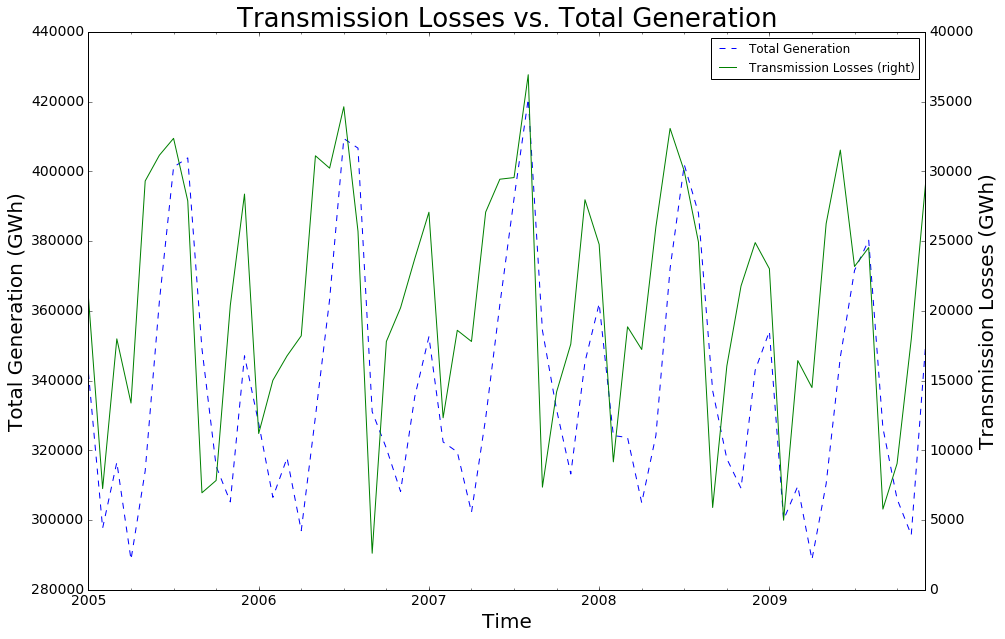

In [18]:
# Transmissions Losses (losses2) and its correlation with Total Net Generation (gen_total)

a = comb['gen_tot'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Total Generation')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Total Generation', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Total Generation (GWh)', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)

corr_val = corr_matrix.loc['gen_tot','losses2']
print('Correlation:', corr_val)

We also identified a set of second-level influencers on Transmission Losses in various temperature measurements, such as Cooling Degree Days.

Correlation: 0.464652437912


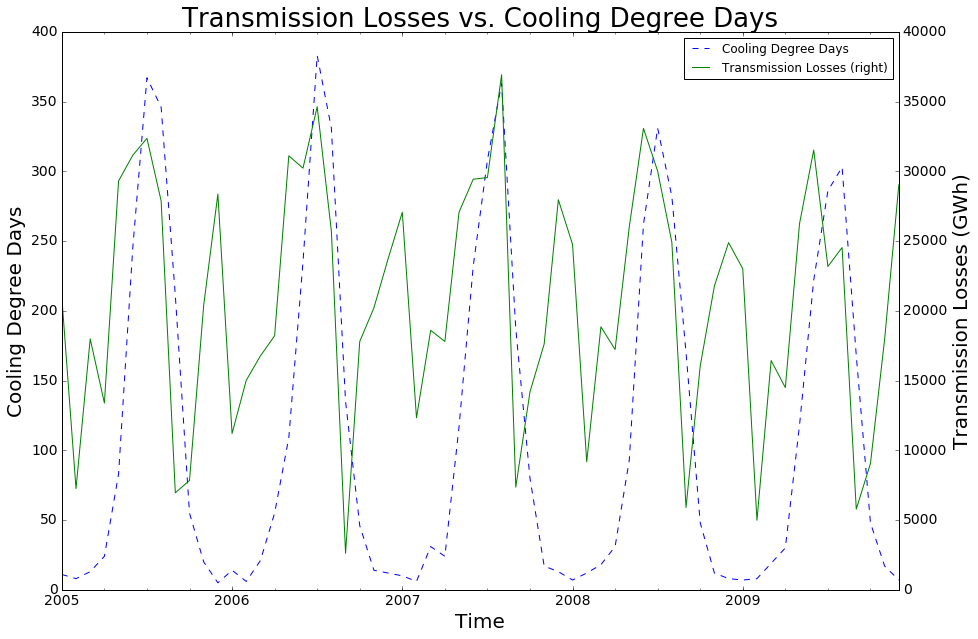

In [19]:
# Transmissions Losses (losses2) and Cooling Degree Days (CDD)

a = comb['CDD'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Cooling Degree Days')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Cooling Degree Days', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Cooling Degree Days', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['CDD','losses2']
print('Correlation:', corr_val)

Temperature was also related to total generations, which makes sense in the context of high demand for air conditioning in summer months.

Correlation: 0.566432652173


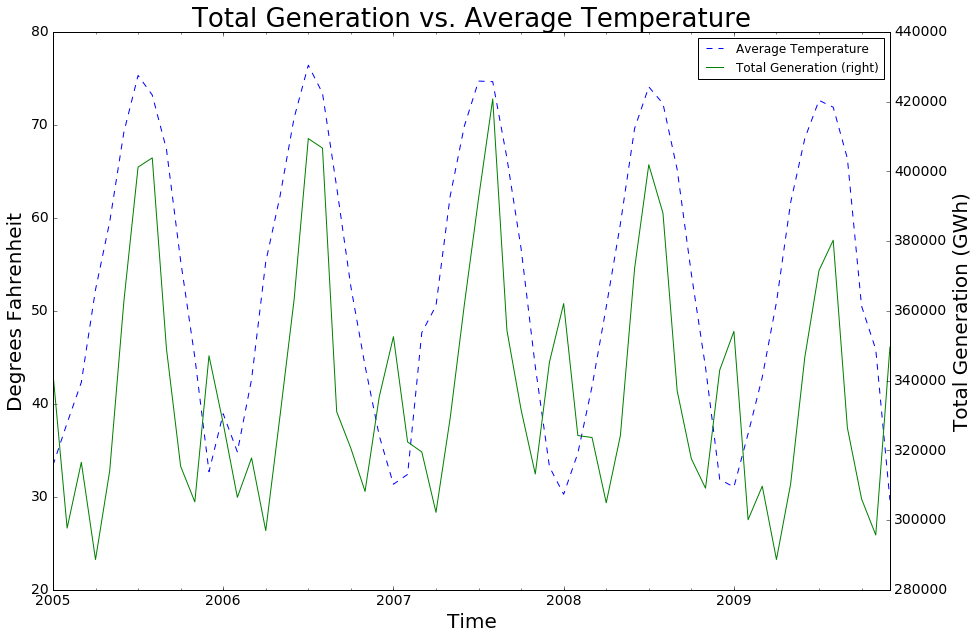

In [20]:
# Plot of Total Generation and Monthly Average Temperature (TAVG). Note that this is seasonal.

a = comb['TAVG'].plot(figsize=(15,10), legend=True, linestyle='dashed', label='Average Temperature')
b = comb['gen_tot'].plot(secondary_y=True, legend=True, label='Total Generation')

a.set_title('Total Generation vs. Average Temperature', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Degrees Fahrenheit', fontsize=20)
b.set_ylabel('Total Generation (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['TAVG','gen_tot']
print('Correlation:', corr_val)

However, this clearly wasn't the whole story, as total generation is exibiting two cycles for every single temperature cycle. This likely reflects the (smaller) increase in electric heating demand during winter months, as well as increased lighting load associated with shorter days. To explore this further, we instead looked at total generation vs. the deviation from annual mean average temperature - finding a much stronger correlation.

Correlation: 0.716687520151


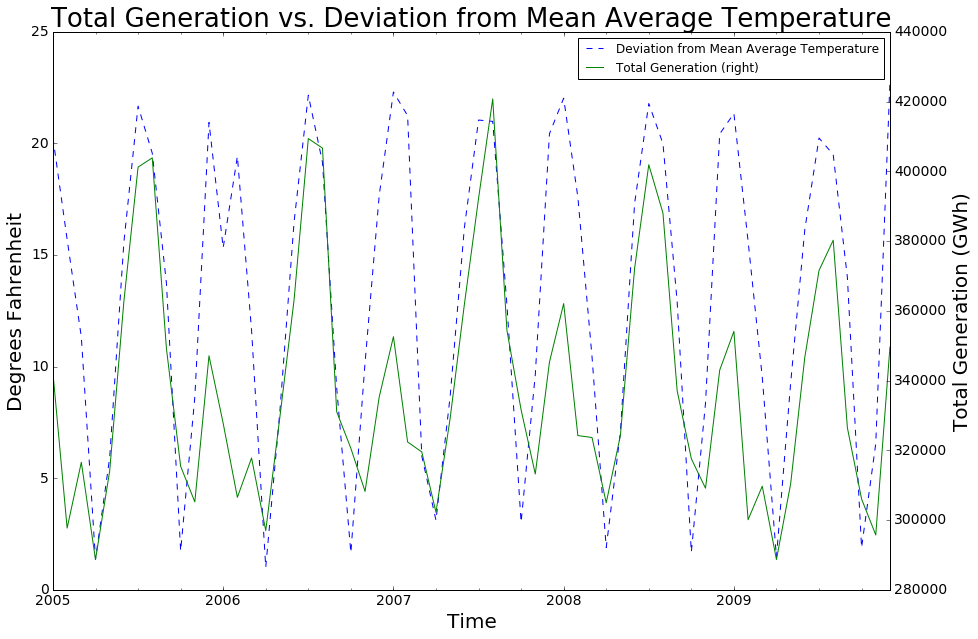

In [21]:
# Plot of Total Generation and Deviation from Mean Average Temperature (DTAVG) to handle.

a = comb['DTAVG'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Deviation from Mean Average Temperature')
b = comb['gen_tot'].plot(secondary_y=True, legend=True, label='Total Generation')

a.set_title('Total Generation vs. Deviation from Mean Average Temperature', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Degrees Fahrenheit', fontsize=20)
b.set_ylabel('Total Generation (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)

corr_val = corr_matrix.loc['DTAVG','gen_tot']
print('Correlation:', corr_val)

Exploring these uneven peaks further, we looked at seasonal differences by dividing into warmer months (March - Aug), which provides a higher correlation between average temperature and transmission losses. 

Correlation: 0.825429896715


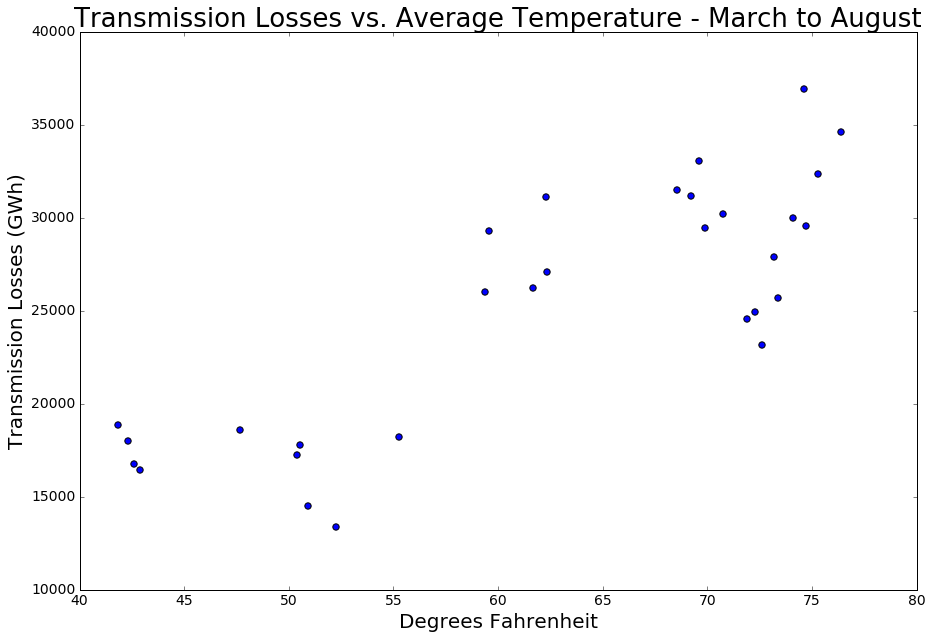

In [22]:
# Make as scatter plot for seasonal slice of data (March - August) for Transmission Losses and Average Temperature
comb_season = comb.loc[(comb.index.month == 3) | (comb.index.month == 4) | (comb.index.month == 5) \
                       | (comb.index.month == 6) | (comb.index.month == 7)| (comb.index.month == 8)]

a = comb_season.plot.scatter(figsize=(15,10), s=40, x='TAVG', y='losses2')
        
a.set_title('Transmission Losses vs. Average Temperature - March to August', fontsize=26)
a.set_xlabel('Degrees Fahrenheit', fontsize=20)
a.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)

corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['TAVG','losses2']
print('Correlation:', corr_val)

and drawing a linear regression over the scatter plot

Correlation: 0.825429896715
slope: 0.00146140268036
y-intercept: 25.5202270328


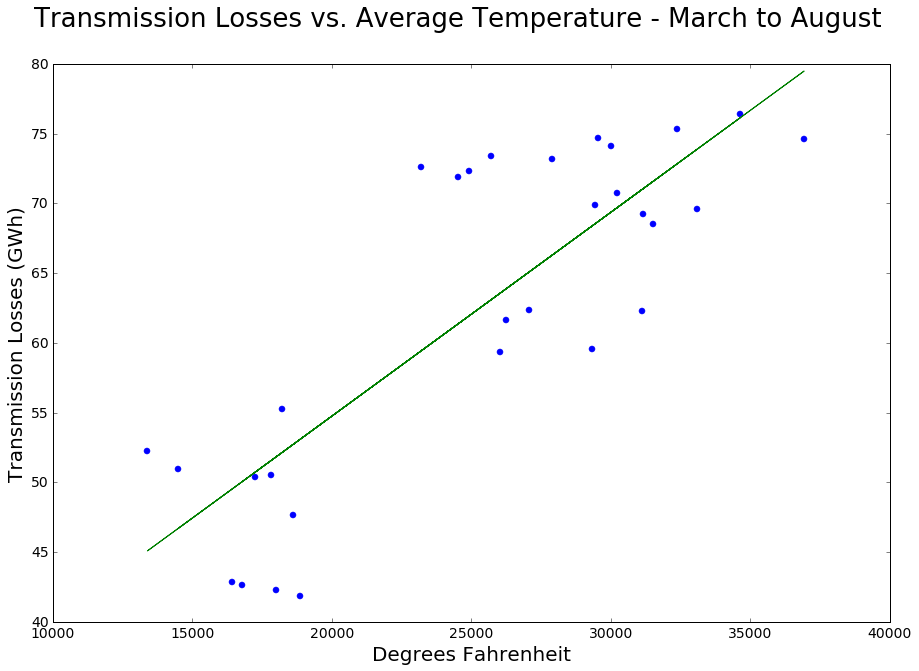

In [23]:
# Linear regression estimate between Temperature Average and Transmission Losses for March - August season. 
# The regression equation is Losses (y) = -32,430+0.15x where x is Temperature Average

comb_season = comb.loc[(comb.index.month == 3) | (comb.index.month == 4) | (comb.index.month == 5) \
                       | (comb.index.month == 6) | (comb.index.month == 7)| (comb.index.month == 8)]

x = comb_season['losses2']
y = comb_season['TAVG']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('Transmission Losses vs. Average Temperature - March to August', \
                    fontsize=26)
plt.pyplot.xlabel('Degrees Fahrenheit', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)
corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['TAVG','losses2']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

Doing the opposite for the colder months gives a negative correlation. 
This can be caused by electricity generation having much higher peak in winter months and the correlation between energy losses is stronger to generation than
to temperature so takes precedence. For a given amount of power, a higher voltage reduces the current and thus the resistive 
losses in the conductor. Raising the voltage by a factor of 10 reduces the current by a corresponding 
factor of 10 and therefore the I2R losses by a factor of 100, provided the same sized conductors are used in both cases.

Correlation: -0.676695561194
slope: -0.00105093355953
y-intercept: 61.0693392444


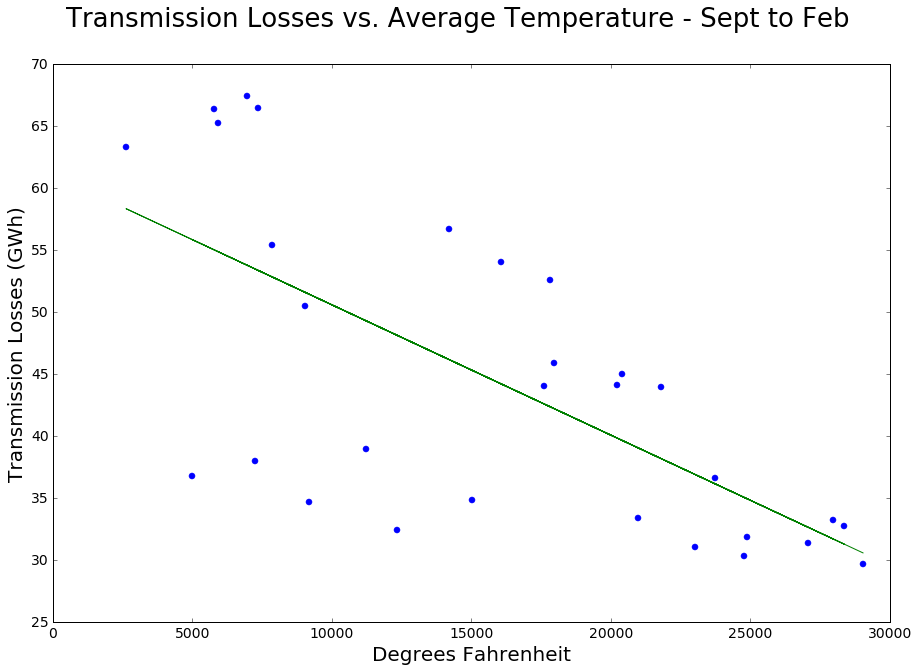

In [24]:
comb_season = comb.loc[(comb.index.month == 9) | (comb.index.month == 10) | (comb.index.month == 11) |\
                       (comb.index.month == 12) | (comb.index.month == 1) | (comb.index.month == 2)]

x = comb_season['losses2']
y = comb_season['TAVG']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('Transmission Losses vs. Average Temperature - Sept to Feb', \
                    fontsize=26)
plt.pyplot.xlabel('Degrees Fahrenheit', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)
corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['TAVG','losses2']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

Going back to transmission losses and CDDs...

Correlation: 0.464652437912


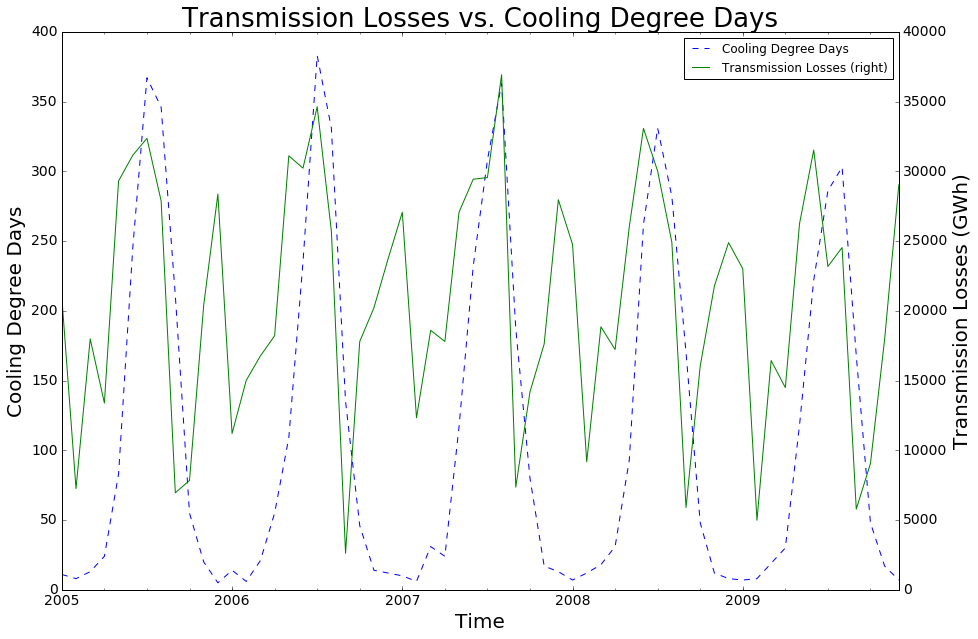

In [25]:
# Transmissions Losses (losses2) and Cooling Degree Days (CDD)

a = comb['CDD'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Cooling Degree Days')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Cooling Degree Days', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Cooling Degree Days', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['CDD','losses2']
print('Correlation:', corr_val)

Correlation: 0.428276302023


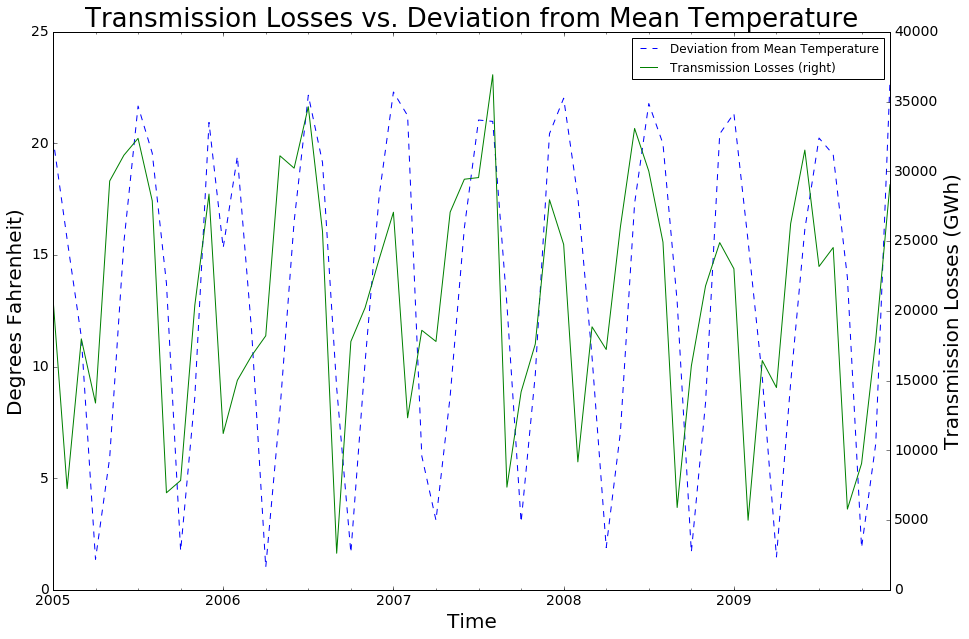

In [26]:
# Test hypothesis that losses are greater at both low and high temperatures. Note 
# both variables relationship to high total generation though. 
# Deviation from annual average (DTAVG) has a better correlation to losses.

a = comb['DTAVG'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Deviation from Mean Temperature')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Deviation from Mean Temperature', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Degrees Fahrenheit)', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['DTAVG','losses2']
print('Correlation:', corr_val)

... and drawing a regression over warmer months, where we would expect to see the largest influence from high temperature days.

Correlation: 0.785474899342
slope: 0.0158711788686
y-intercept: -223.15316492


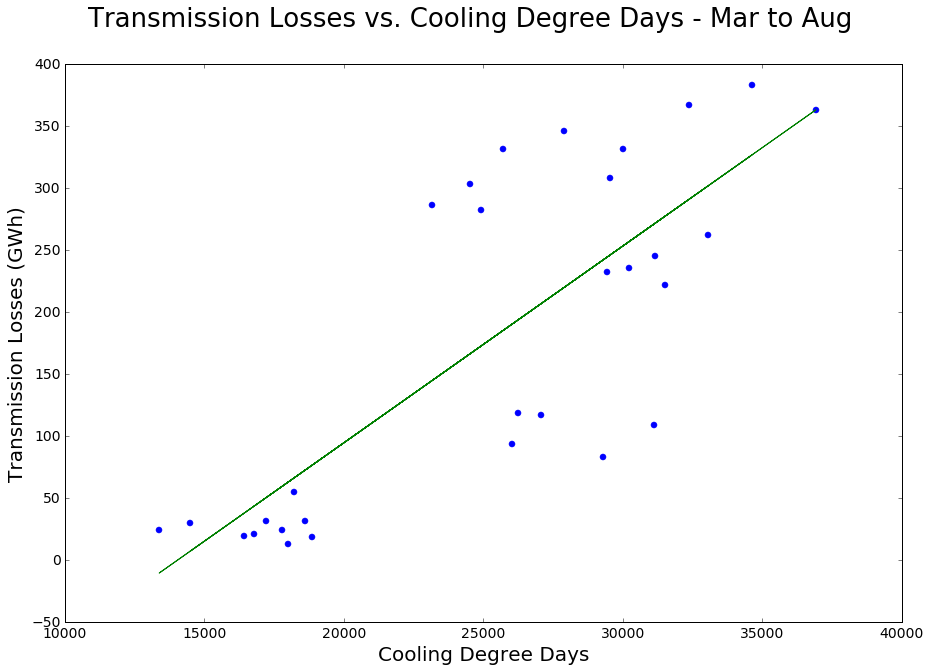

In [27]:
# Transmission Losses (losses2) and Cooling Degree Days (CDD) have more of a seasonal correlation. 
# This graph is filtering for warmer months and show in scatter plot.

comb_season = comb.loc[(comb.index.month == 3) | (comb.index.month == 4) | (comb.index.month == 5) \
                       | (comb.index.month == 6) | (comb.index.month == 7)| (comb.index.month == 8)]

x = comb_season['losses2']
y = comb_season['CDD']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('Transmission Losses vs. Cooling Degree Days - Mar to Aug', \
                    fontsize=26)
plt.pyplot.xlabel('Cooling Degree Days', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)
corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['CDD','losses2']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

We also found a similar relation to heating degree days during cold months.

Correlation: 0.673590535439
slope: 0.0250954140823
y-intercept: 130.86233788


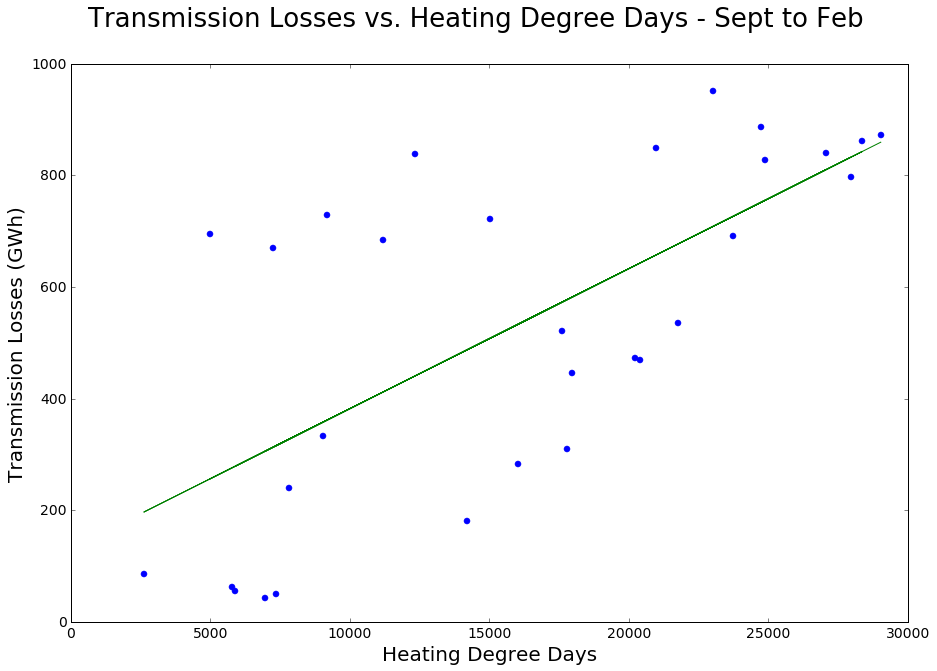

In [28]:
# Corresponding Transmissions Losses (losses2) and Heating Degree Days (HDD) graph for cooler months.

comb_season = comb.loc[(comb.index.month == 9) | (comb.index.month == 10) | (comb.index.month == 11) |\
                       (comb.index.month == 12) | (comb.index.month == 1) | (comb.index.month == 2)]

x = comb_season['losses2']
y = comb_season['HDD']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('Transmission Losses vs. Heating Degree Days - Sept to Feb', \
                    fontsize=26)
plt.pyplot.xlabel('Heating Degree Days', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)
corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['HDD','losses2']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

Raw transmission loss numbers can be deceiving, due to the fact that different amounts of electricity are used in different years. A better measure is looking at electrical losses as a percent of total generation to remove the impact of changing levels of annual generation.

Correlation: 0.17797436075


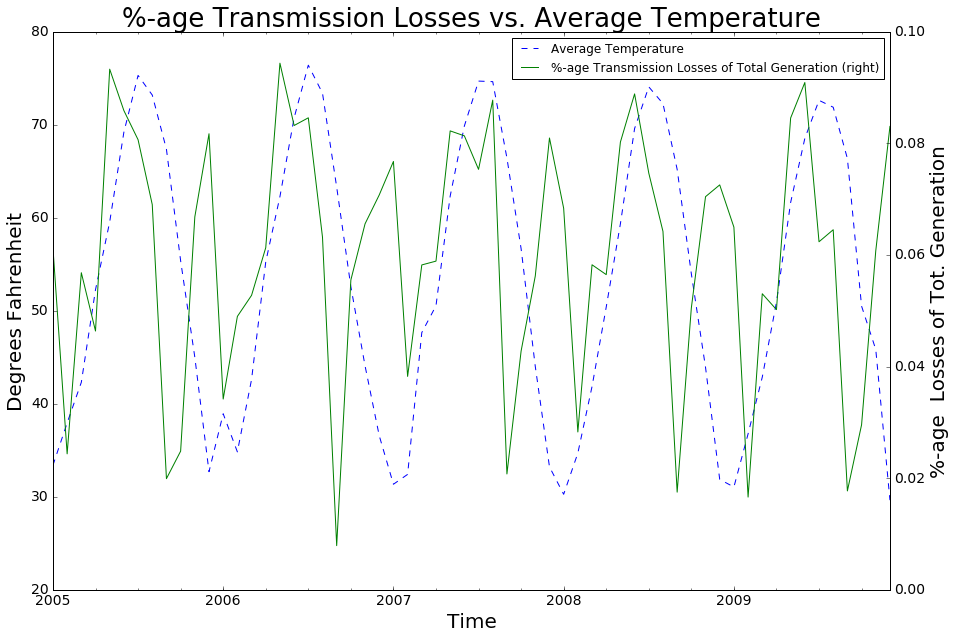

In [50]:
# Plot Percentage of Transmission Losses of Total Generation to Monthly Average Temperature. 

a = comb['TAVG'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Average Temperature')
b = comb['losses2_perc'].plot(secondary_y=True, legend=True, label='%-age Transmission Losses of Total Generation')

# axes[0].set_ylim(20, 80)
# b.set_ylim(-5000, 5000) 

a.set_title('%-age Transmission Losses vs. Average Temperature', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Degrees Fahrenheit', fontsize=20)
b.set_ylabel('%-age  Losses of Tot. Generation', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['TAVG','losses2_perc']
print('Correlation:', corr_val)

Correlation: 0.272817788578


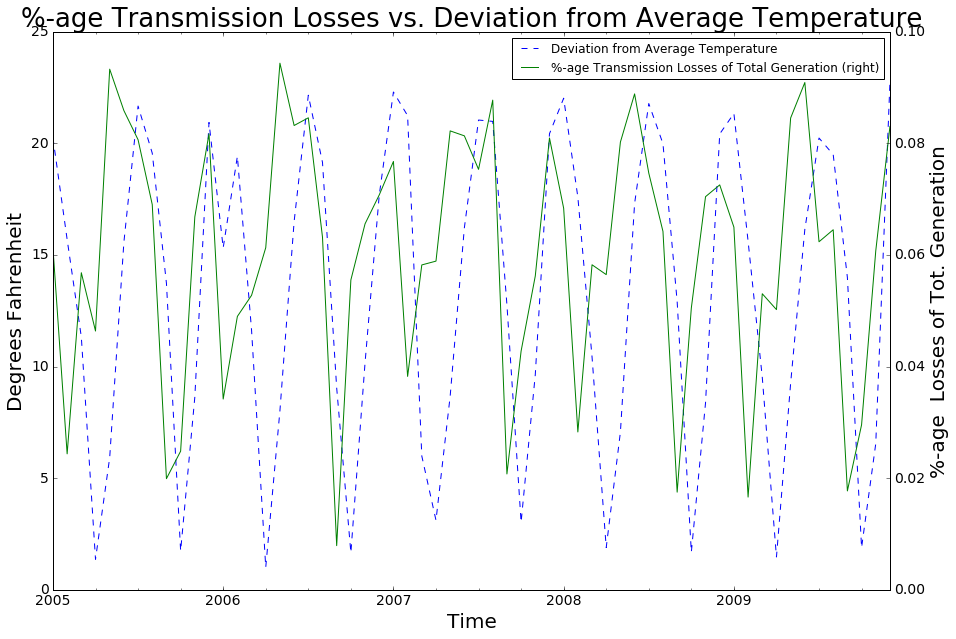

In [51]:
# Plot Percentage of Transmission Losses of Total Generation to Monthly Average Temperature. 

a = comb['DTAVG'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Deviation from Average Temperature')
b = comb['losses2_perc'].plot(secondary_y=True, legend=True, label='%-age Transmission Losses of Total Generation')

# axes[0].set_ylim(20, 80)
# b.set_ylim(-5000, 5000) 

a.set_title('%-age Transmission Losses vs. Deviation from Average Temperature', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Degrees Fahrenheit', fontsize=20)
b.set_ylabel('%-age  Losses of Tot. Generation', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['DTAVG','losses2_perc']
print('Correlation:', corr_val)

As you can see above, removing the the influence of generation levels increasing (and therefore making more electricity available to lose) reduces our correlation dramatically.

We also compared this difference looking at seasonal weather.

Correlation: 0.615460922282
slope: 497.454414689
y-intercept: 26.7330597489


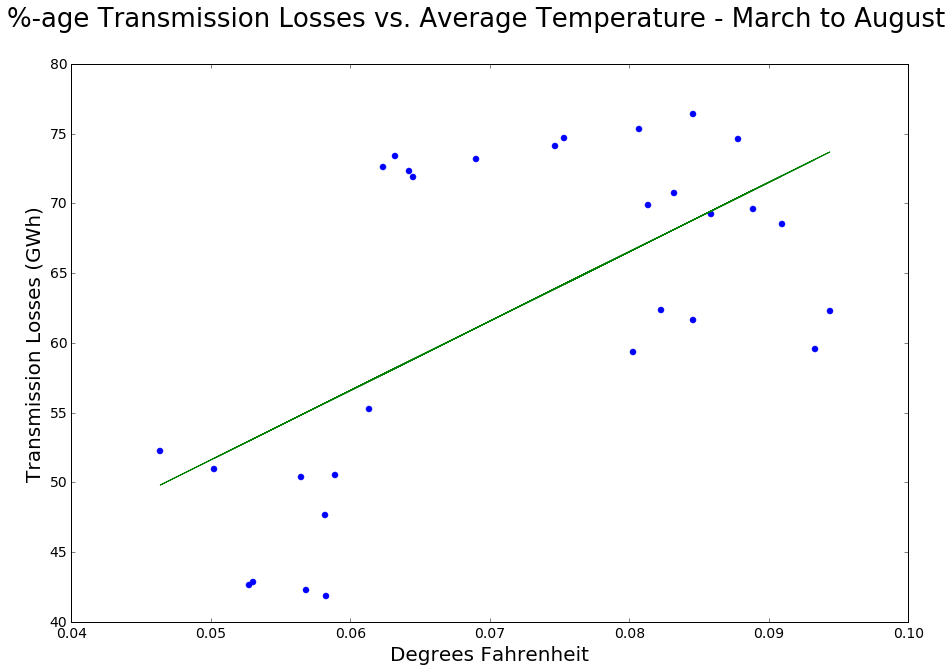

In [31]:
# Seasonal weather data correlation and plot with percentage losses, summer months

# comb_season = comb.loc[(comb.index.month == 9) | (comb.index.month == 10) | (comb.index.month == 11) |\
#                        (comb.index.month == 12) | (comb.index.month == 1) | (comb.index.month == 2)]
comb_season = comb.loc[(comb.index.month == 3) | (comb.index.month == 4) | (comb.index.month == 5) \
                       | (comb.index.month == 6) | (comb.index.month == 7)| (comb.index.month == 8)]

x = comb_season['losses2_perc']
y = comb_season['TAVG']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('%-age Transmission Losses vs. Average Temperature - March to August', \
                    fontsize=26)
plt.pyplot.xlabel('Degrees Fahrenheit', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)
corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['TAVG','losses2_perc']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

Correlation: -0.665613898162
slope: -358.009296081
y-intercept: 61.6109266305


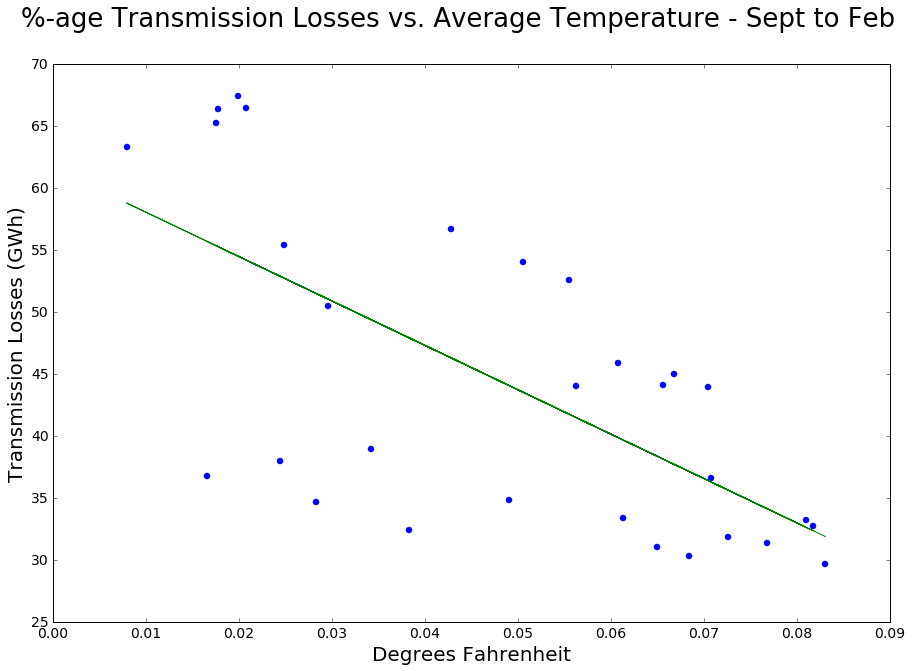

In [32]:
# Seasonal weather data correlation and plot with percentage losses, winter months

comb_season = comb.loc[(comb.index.month == 9) | (comb.index.month == 10) | (comb.index.month == 11) |\
                       (comb.index.month == 12) | (comb.index.month == 1) | (comb.index.month == 2)]
# comb_season = comb.loc[(comb.index.month == 3) | (comb.index.month == 4) | (comb.index.month == 5) \
#                        | (comb.index.month == 6) | (comb.index.month == 7)| (comb.index.month == 8)]

x = comb_season['losses2_perc']
y = comb_season['TAVG']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('%-age Transmission Losses vs. Average Temperature - Sept to Feb', \
                    fontsize=26)
plt.pyplot.xlabel('Degrees Fahrenheit', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)
corr_matrix_season = comb_season.corr()
corr_val = corr_matrix_season.loc['TAVG','losses2_perc']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

We then created z-scores for the columns to see the normalized deviation from the mean for each observation.

In [33]:
cols = list(comb.columns)
# Remove non-numerical columns from z-score creation.
# cols.remove('Coverage') 
if 'TAVG_zscore' not in comb.columns:
    for col in cols:
        col_zscore = col + '_zscore'
        comb[col_zscore] = (comb[col] - comb[col].mean())/comb[col].std()
comb.iloc[:,-60:].head()

PCP_zscore  TAVG_zscore  PDSI_zscore  PHDI_zscore  ZNDX_zscore  \
date                                                                         
2005-01-01    0.316758    -1.313844     3.124206     2.367772     1.773560   
2005-02-01   -0.979992    -1.012766     0.205448     2.091561    -0.132392   
2005-03-01   -0.412664    -0.723600     0.055472     1.749808    -0.495138   
2005-04-01    0.053356    -0.064539     0.049703     1.553182    -0.070910   
2005-05-01    0.438329     0.417847     0.049703     1.384647    -0.052465   

            PMDI_zscore  CDD_zscore  HDD_zscore  SP01_zscore  SP02_zscore  \
date                                                                        
2005-01-01     2.552677   -0.812847    1.560689     0.903033     0.287621   
2005-02-01     2.173824   -0.837297    0.990055    -0.205008     0.659783   
2005-03-01     1.608138   -0.796546    0.903982    -0.454006    -0.470486   
2005-04-01     1.338270   -0.706894   -0.151213     0.093789    -0.208594   
2005-05-01     1.104730   -0.226032   -0.540136    -0.429107    -0.249946   

                  ...          he_abs_min_zscore  hn_abs_min_zscore  \
date              ...                                                 
2005-01-01        ...                  -1.664087          -0.125519   
2005-02-01        ...                  -0.370206          -0.114186   
2005-03-01        ...                  -0.643127          -0.136853   
2005-04-01        ...                   0.257182          -0.091519   
2005-05-01        ...                  -1.580047          -0.125519   

            hp_max_zscore  ht_max_zscore  he_max_zscore  hn_max_zscore  \
date                                                                     
2005-01-01       4.057045       2.827199       0.058335       4.925923   
2005-02-01      -0.442129      -0.206424       0.343294       1.168053   
2005-03-01      -0.442129      -0.467368       0.397205       0.987994   
2005-04-01       0.652908       0.359794       0.554538      -0.024550   
2005-05-01       1.414673       3.988494       3.631877       1.890631   

            hp_abs_max_zscore  ht_abs_max_zscore  he_abs_max_zscore  \
date                                                                  
2005-01-01           4.057045           2.827199           0.272252   
2005-02-01          -0.442129          -0.206424           0.317417   
2005-03-01          -0.442129          -0.467368           0.371395   
2005-04-01           0.652908           0.359794           0.528923   
2005-05-01           1.414673           3.988494           3.610082   

            hn_abs_max_zscore  
date                           
2005-01-01           3.937235  
2005-02-01           0.731503  
2005-03-01           0.689611  
2005-04-01          -0.285873  
2005-05-01           2.010205  

[5 rows x 60 columns]

and plotting losses z-scores with generation and average temperature.

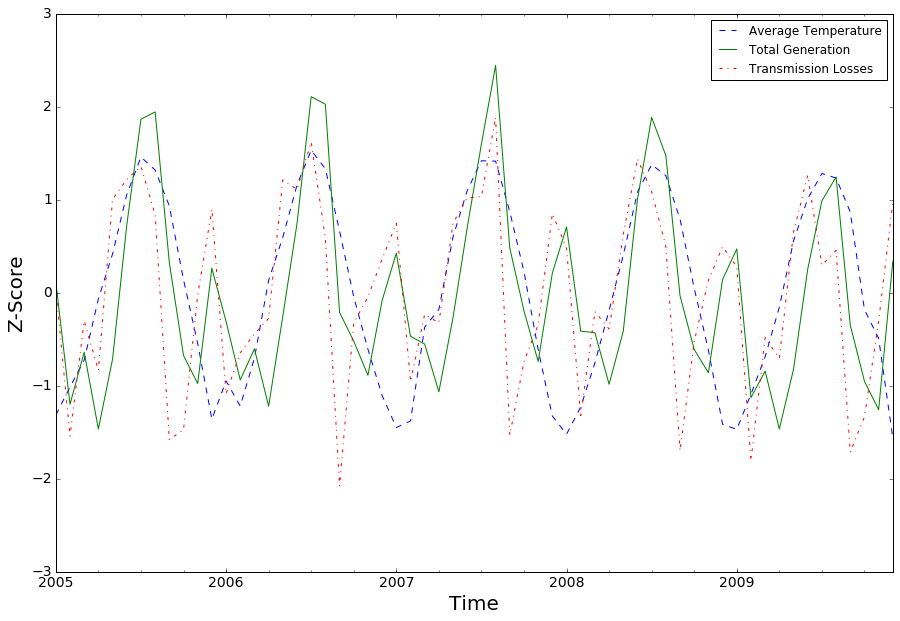

In [34]:
# Plot z-scores of Transmissions Losses (losses2), Total Generation (gen_tot) and Monthly Average Temperature (TAVG). 

a = comb['TAVG_zscore'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Average Temperature')
b = comb['gen_tot_zscore'].plot(legend=True, label='Total Generation')
c = comb['losses2_zscore'].plot(legend=True, linestyle='dashdot', label='Transmission Losses')

# a.set_title('Normalized Z-Score', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Z-Score', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)

To begin a regression analysis, we again plot losses and total generation

Correlation: 0.609971967368


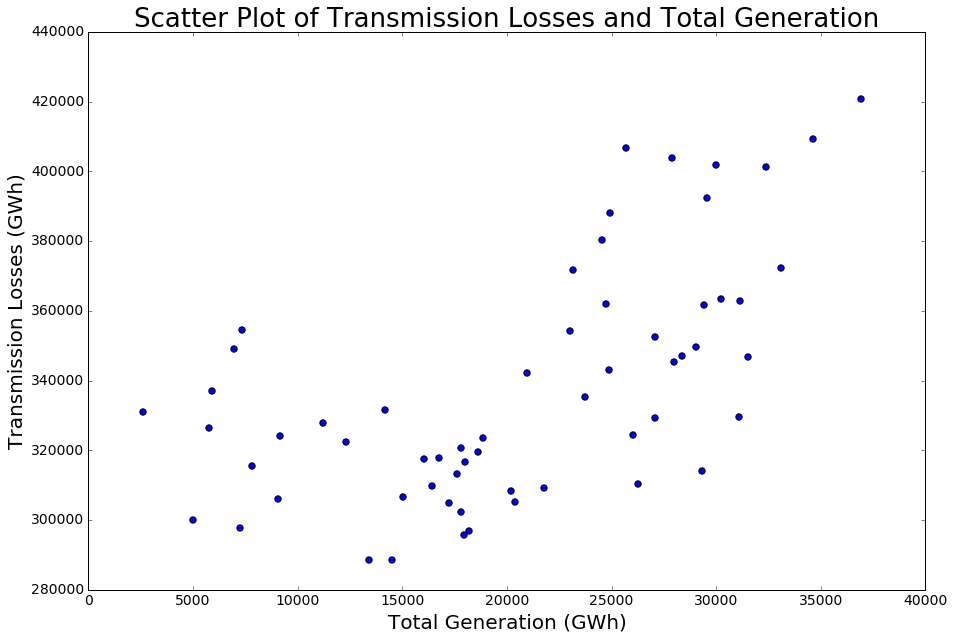

In [35]:
# Make scatter plot for relationships, e.g. Transmission Losses and Total Generation as start of regression analysis
a = comb.plot.scatter(figsize=(15,10), s=40, x='losses2', y='gen_tot')
        
a.set_title('Scatter Plot of Transmission Losses and Total Generation', fontsize=26)
a.set_xlabel('Total Generation (GWh)', fontsize=20)
a.set_ylabel('Transmission Losses (GWh)', fontsize=20)

a.tick_params(labelsize=14)

corr_matrix = comb.corr()
corr_val = corr_matrix.loc['losses2','gen_tot']
print('Correlation:', corr_val)

Adding a regression line

Correlation: 0.609971967368
slope: 0.156301402338
y-intercept: -32257.1578919


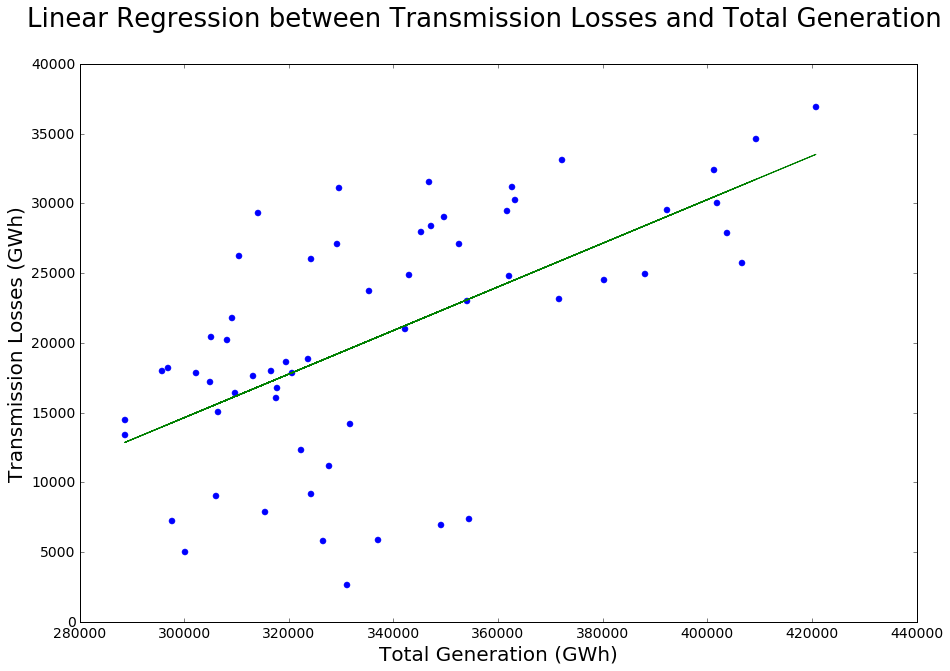

In [36]:
# Linear regression estimate between Total Generation and Transmission Losses. 
# The regression equation is Losses (y) = -32,257+0.156x where x is Total Generation

x = comb['gen_tot']
y = comb['losses2']

#fit with np.polyfit
plt.pyplot.figure(figsize=(15,10))
m, b = np.polyfit(x, y , 1)
plt.pyplot.plot(x, y, '.', ms=12)
plt.pyplot.plot(x, m*x + b, '-')
plt.pyplot.suptitle('Linear Regression between Transmission Losses and Total Generation', fontsize=26)
plt.pyplot.xlabel('Total Generation (GWh)', fontsize=20)
plt.pyplot.ylabel('Transmission Losses (GWh)', fontsize=20)
plt.pyplot.tick_params(labelsize=14)

corr_matrix = comb.corr()
corr_val = corr_matrix.loc['losses2','gen_tot']
print('Correlation:', corr_val)

print('slope:', m)
print('y-intercept:', b)

and using the above formula to create predicted losses and residiual based on total generation regressoin

In [37]:
# Use the above formula in order to create predicted losses and residiual based on total generation regression.

if 'losses2_pred_gen_total' not in comb.columns:
    for i in comb.index:
        comb.ix[i, 'losses2_pred_gen_total'] = -32257 + 0.156*comb.ix[i, 'gen_tot']
        comb.ix[i,'losses2_resid_gen_total'] = comb.ix[i,'losses2'] - comb.ix[i,'losses2_pred_gen_total']
comb.iloc[:,-5:].head()

ht_abs_max_zscore  he_abs_max_zscore  hn_abs_max_zscore  \
date                                                                  
2005-01-01           2.827199           0.272252           3.937235   
2005-02-01          -0.206424           0.317417           0.731503   
2005-03-01          -0.467368           0.371395           0.689611   
2005-04-01           0.359794           0.528923          -0.285873   
2005-05-01           3.988494           3.610082           2.010205   

            losses2_pred_gen_total  losses2_resid_gen_total  
date                                                         
2005-01-01            21120.280067              -155.450272  
2005-02-01            14183.863611             -6930.925045  
2005-03-01            17127.920817               861.312954  
2005-04-01            12776.392781               610.223586  
2005-05-01            16742.834401             12563.381504

and then correlating actual, predicted, and residual values

In [38]:
# The correlations among the actual, predicted and residual is as follows.

comb[['gen_tot','losses2', 'losses2_pred_gen_total', 'losses2_resid_gen_total']].corr()

gen_tot   losses2  losses2_pred_gen_total  \
gen_tot                  1.000000  0.609972                1.000000   
losses2                  0.609972  1.000000                0.609972   
losses2_pred_gen_total   1.000000  0.609972                1.000000   
losses2_resid_gen_total  0.001484  0.793328                0.001484   

                         losses2_resid_gen_total  
gen_tot                                 0.001484  
losses2                                 0.793328  
losses2_pred_gen_total                  0.001484  
losses2_resid_gen_total                 1.000000

Now that we have partialed out the impact of total generation on losses by linear regression, we can test to correlate with residuals (e.g. TAVG). This is a 'first-order' semi-partial (or part) correlation test. No strong correlation is shown. 
Test also Cooling Degree Days (CDD) and ht_abs_mean/ht_sum as had reasonable first degree correlation 
to Transmission Losses as per earlier analysis. As per below space weather (e.g. ht_abs_mean) has higher
correlation to the residual than land surface temperature. Even land surface percipitation has higher correlation.

In [39]:
corr_matrix = comb.corr()
corr_val_TAVG = corr_matrix.loc['losses2_resid_gen_total','TAVG']
print('Correlation for TAVG to residual', corr_val_TAVG)
print()
print('Other absolute correlations to residual gen_tot:')

corr_val = corr_matrix.loc['losses2_resid_gen_total',]
print(corr_val.abs().sort_values(ascending=False).head(50))

Correlation for TAVG to residual -0.0532496079217

Other absolute correlations to residual gen_tot:
losses2_resid_gen_total    1.000000
losses2_perc               0.914942
losses_perc                0.914942
losses_perc_zscore         0.914942
losses2_perc_zscore        0.914942
losses2_zscore             0.793328
losses2                    0.793328
net_imports_est            0.558733
net_imports_est_zscore     0.558733
ht_mean_zscore             0.283570
ht_mean                    0.283570
ht_abs_mean_zscore         0.283489
ht_abs_mean                0.283489
losses_est                 0.276232
losses_est_zscore          0.276232
hp_abs_mean                0.255647
hp_abs_mean_zscore         0.255647
hp_mean_zscore             0.254641
hp_mean                    0.254641
hp_abs_sum_zscore          0.254405
hp_abs_sum                 0.254405
hp_sum_zscore              0.254209
hp_sum                     0.254209
losses_est_perc_zscore     0.248939
losses_est_perc            0.248939


#### Transmission vs Magnetic Flux

We then turned our attention to the effect of magnetic flux on losses.

We first considered the monthly sum of magnetic flux

In [40]:
# How does the sum of total magnetic flux relate to transmission losses?

a = comb['ht_sum'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Total Magnetic Field Sum')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Total Magnetic Field Sum', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Total Magnetic Field Sum', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['ht_sum','losses2']
print('Correlation:', corr_val)

Correlation: 0.479752443625


And then average magnetic flux

In [41]:
# And the mean of total magnetic field?

a = comb['ht_mean'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Total Magnetic Field Mean')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Total Magnetic Field Mean', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Total Magnetic Field Mean', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['ht_mean','losses2']
print('Correlation:', corr_val)

Correlation: 0.509620439586


It turns out that flux maximums are a much poorer fit than sum or mean.

In [42]:
# Monthly magnetic field maximums are a much poorer fit for monthly losses.

a = comb['ht_max'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Total Magnetic Field Max')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Total Magnetic Field Max', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Total Magnetic Field Max', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['ht_max','losses2']
print('Correlation:', corr_val)

Correlation: 0.22407097382


In [43]:
# Monthly magnetic field minimums

a = comb['ht_min'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Total Magnetic Field Min')
b = comb['losses2'].plot(secondary_y=True, legend=True, label='Transmission Losses')

a.set_title('Transmission Losses vs. Total Magnetic Field Min', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Total Magnetic Field Min', fontsize=20)
b.set_ylabel('Transmission Losses (GWh)', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['ht_min','losses2']
print('Correlation:', corr_val)

Correlation: 0.354105170787


### Other relationships

Out of curiosity, review the correlation between space weather and land surface weather.

Correlation: 0.6626184648


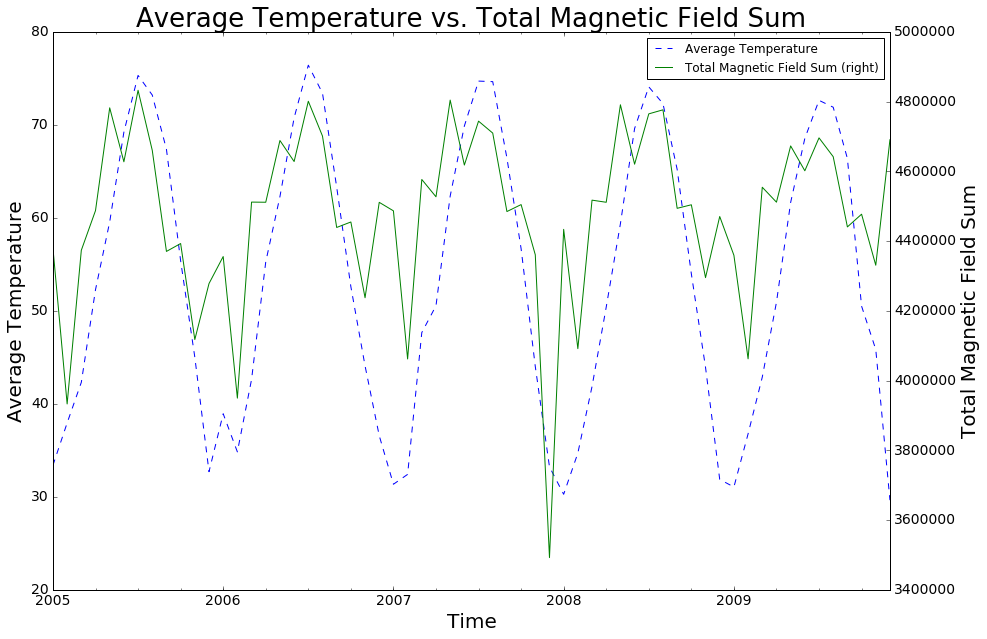

In [44]:
# Graph of Temperature correlation with magnetic activity.

a = comb['TAVG'].plot(figsize=(15,10), linestyle='dashed', legend=True, label='Average Temperature')
b = comb['ht_sum'].plot(secondary_y=True, legend=True, label='Total Magnetic Field Sum')

a.set_title('Average Temperature vs. Total Magnetic Field Sum', fontsize=26)
a.set_xlabel('Time', fontsize=20)
a.set_ylabel('Average Temperature', fontsize=20)
b.set_ylabel('Total Magnetic Field Sum', fontsize=20)
a.tick_params(labelsize=14)
b.tick_params(labelsize=14)
corr_val = corr_matrix.loc['TAVG','ht_sum']
print('Correlation:', corr_val)

### Conclusion

The analysis showed a strong correlation between Transmission Losses and Total Generation. Average Temperature and associated seasonal Cooling Degree Days and Heating Degree Days have a clear impact on Total Generation and Transmission Losses. However, the impact is higher on Total Generation and as such part of its correlation with Transmission Losses can be attributed to this first level relationship. After having partialed out the impact of Total Generation on Transmission Losses by linear regression, we find that Space Weather has a higher correlation to the residual than Average Land Surface Temperature.

Additionally, this project has taught us a lot about the challenges of finding, cleaning, and combining different datasets. We began this project thinking that the data would be readily available for analysis, and in the end we spent nearly 2/3rds of our available time getting the data into workable formats. This was a limitation of our project (less time for analysis), but still a valuable lesson and an opportunity to practice many of the less-glamorous skills needed in data science.